In [1]:

# yeni hali 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import os

import tensorflow as tf

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,  LSTM , BatchNormalization


2024-02-03 20:22:41.159095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import yfinance as yf

In [3]:
import os

if os.path.exists('datas'):
    #sil
    os.system('rm -rf datas')

In [4]:
period = '3000d'

#tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'GOOGL', 'TSLA', 'NVDA', 'PYPL', 'ADBE','BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD','BCH-USD', 'BNB-USD', 'LINK-USD', 'ADA-USD', 'XLM-USD', 'SOL-USD', 'TRX-USD']

tickers = ['SOL-USD']


In [5]:
def indir_ve_df_olustur(tickers, period):
    # Her bir hisse senedi için boş bir sözlük oluşturun
    pariteler = {}

    # Her bir hisse senedi için döngü oluşturun ve verileri indirin
    for ticker in tickers:
        try:
            # Hisse senedi verilerini indirin
            veri = yf.download(ticker, period=period)
            
            # Veriyi sözlüğe ekleyin
            pariteler[ticker] = veri
        except Exception as e:
            print(f"{ticker} için veri indirilirken bir hata oluştu: {str(e)}")

    # Her bir hisse senedi için ayrı bir veri çerçevesi oluşturun
    df_listesi = [veri for veri in pariteler.values()]

    return df_listesi

In [6]:
#pariteler adında klasör oluştur :

import os 

if not os.path.exists('datas/pariteler'):
    os.makedirs('datas/pariteler')



In [7]:
datasets = indir_ve_df_olustur(tickers, period)

#pariteler içine kaydet 

for i in range(len(datasets)):
    datasets[i].to_csv(f'datas/pariteler/{tickers[i]}.csv')
    #print(f'{tickers[i]} verisi csv olarak kaydedildi')


[*********************100%%**********************]  1 of 1 completed


In [8]:
window = 30

def veri_hazirla(df, window):
    # Veri çerçevesinin kopyasını oluşturun
    df = df.copy()
    
    # Veri çerçevesine yeni sütunlar ekleyin
    for i in range(1, window + 1):
        df[f'Önceki_{i}_Açılış'] = df['Open'].shift(i)
        df[f'Önceki_{i}_Yüksek'] = df['High'].shift(i)
        df[f'Önceki_{i}_Düşük'] = df['Low'].shift(i)
        df[f'Önceki_{i}_Kapanış'] = df['Close'].shift(i)
        df[f'Önceki_{i}_Adj'] = df['Adj Close'].shift(i)
        df[f'Önceki_{i}_Hacim'] = df['Volume'].shift(i)
        
    # NaN değerleri bırakın
    df.dropna(inplace=True)
    
    return df

# Her bir veri çerçevesi için döngü oluşturun ve verileri hazırlayın
data_windowed = [veri_hazirla(df, window) for df in datasets]


if not os.path.exists('datas/windowed'):
    os.makedirs('datas/windowed')

# Her bir veri çerçevesi için parite ismiyle birlikte windowed klasörüne kaydedin 
for i in range(len(data_windowed)):
    data_windowed[i].to_csv(f'datas/windowed/{tickers[i]}_windowed.csv')
    print(f'{tickers[i]} verisi windowed olarak kaydedildi')



/var/folders/w9/3z_zbj956tj44glgzg44rgbr0000gn/T/ipykernel_50734/1521282515.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Önceki_{i}_Düşük'] = df['Low'].shift(i)
/var/folders/w9/3z_zbj956tj44glgzg44rgbr0000gn/T/ipykernel_50734/1521282515.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Önceki_{i}_Kapanış'] = df['Close'].shift(i)
/var/folders/w9/3z_zbj956tj44glgzg44rgbr0000gn/T/ipykernel_50734/1521282515.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

SOL-USD verisi windowed olarak kaydedildi


In [9]:
#data_windowed

In [10]:
#her bir veri çerçevesi için X  = features(öncekiler) y = labels olan veriyapısını kuruyoruz (labels  = ['Open','High', 'Low', 'Close', 'Adj Close', 'Volume'])

def X_y_olustur(df, window, labels):
    # Veri çerçevesinin kopyasını oluşturun
    df = df.copy()
    
    # Özellikler ve etiketler için boş listeler oluşturun
    X = []
    y = []
    
    # Her bir satır için döngü oluşturun
    for i in range(len(df) - window):
        # Özellikler için satırı alın
        X_row = df.iloc[i:i + window].values
        
        # Etiketler için satırı alın
        y_row = df[labels].iloc[i + window].values
        
        # Özellikleri ve etiketleri listelere ekleyin
        X.append(X_row)
        y.append(y_row)
        
    # Listeleri numpy dizilerine dönüştürün
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Her bir veri çerçevesi için döngü oluşturun ve X ve y oluşturun
X_y = [X_y_olustur(df, window, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']) for df in data_windowed]
#X_y = [X_y_olustur(df, window, ['Close' ,'Volume']) for df in data_windowed]

# Her bir veri çerçevesi için parite ismiyle birlikte numpy klasörüne kaydedin

if not os.path.exists('datas/numpy'):
    os.makedirs('datas/numpy')
for i in range(len(X_y)):
    np.save(f'datas/numpy/{tickers[i]}_X.npy', X_y[i][0])
    np.save(f'datas/numpy/{tickers[i]}_y.npy', X_y[i][1])
    print(f'{tickers[i]} verisi X ve y olarak kaydedildi')
    



SOL-USD verisi X ve y olarak kaydedildi


In [11]:
# her bir veri çerçevesi için train test split yapalım time series için doğru yolla yapmak gerekiyor

def train_test_split(X, y, test_size):
        # Test boyutunu hesaplayın

        
        #test_size = int(len(X) * test_size) #yüzdelikli tercih değil

        
        # Eğitim ve test veri kümelerini ayırın
        X_train = X[:-test_size]
        X_test = X[-test_size:]
        y_train = y[:-test_size]
        y_test = y[-test_size:]
        
        return X_train, X_test, y_train, y_test

# Her bir veri çerçevesi için döngü oluşturun ve train ve test veri kümelerini ayırın
test_size = 60
X_train_test = [train_test_split(X_y[i][0], X_y[i][1], 60) for i in range(len(X_y))]

In [12]:
# her bir veri çerçevesi için zerobase normalizasyon ve minmax scaling yapalım

def normalize(X_train, X_test, y_train, y_test):
    # Zerobase normalizasyonu uygulayın
    X_train = (X_train - X_train.mean()) / X_train.std()
    X_test = (X_test - X_test.mean()) / X_test.std()
    y_train = (y_train - y_train.mean()) / y_train.std()
    y_test = (y_test - y_test.mean()) / y_test.std()
    
    # Minmax scaling uygulayın
    X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
    X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())
    y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())
    y_test = (y_test - y_test.min()) / (y_test.max() - y_test.min())
    
    return X_train, X_test, y_train, y_test

# Her bir veri çerçevesi için döngü oluşturun ve normalizasyon ve ölçeklendirme uygulayın

X_train_test_normalized = [normalize(X_train_test[i][0], X_train_test[i][1], X_train_test[i][2], X_train_test[i][3]) for i in range(len(X_train_test))]




In [13]:
# her bir veri çerçevesi için LSTM modeli oluşturalım

def build_model(input_shape ,  output_shape):
    # Modeli oluşturun
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(LSTM(128 , return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(output_shape))
    
    return model

In [14]:
# her bir veri çerçevesi için modeli eğitelim

if not os.path.exists('datas/models'):
    os.makedirs('datas/models')

models=[]

batch_size = 64

epochs = 100

for i in range(len(X_train_test_normalized)):
    # Modeli oluşturun
    model = build_model(X_train_test_normalized[i][0].shape[1:], X_train_test_normalized[i][2].shape[1])
    
    # Modeli derleyin
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Modeli eğitin
    model.fit(X_train_test_normalized[i][0], X_train_test_normalized[i][2], batch_size=batch_size, epochs=epochs, validation_data=(X_train_test_normalized[i][1], X_train_test_normalized[i][3]))
    
    # Modeli kaydedin
    model.save(f'datas/models/{tickers[i]}_model.h5')
    
    # Modeli listeye ekleyin
    models.append(model)
    print(f'{tickers[i]} modeli eğitildi ve kaydedildi')
    
    

Epoch 1/100
20/20 [==============================] - 11s 168ms/step - loss: 0.6683 - val_loss: 0.0407
Epoch 2/100
20/20 [==============================] - 2s 90ms/step - loss: 0.2971 - val_loss: 0.0336
Epoch 3/100
20/20 [==============================] - 2s 89ms/step - loss: 0.2092 - val_loss: 0.0416
Epoch 4/100
20/20 [==============================] - 2s 87ms/step - loss: 0.1608 - val_loss: 0.0382
Epoch 5/100
20/20 [==============================] - 2s 91ms/step - loss: 0.1168 - val_loss: 0.0371
Epoch 6/100
20/20 [==============================] - 2s 104ms/step - loss: 0.0923 - val_loss: 0.0369
Epoch 7/100
20/20 [==============================] - 2s 98ms/step - loss: 0.0726 - val_loss: 0.0364
Epoch 8/100
20/20 [==============================] - 2s 106ms/step - loss: 0.0591 - val_loss: 0.0360
Epoch 9/100
20/20 [==============================] - 2s 100ms/step - loss: 0.0463 - val_loss: 0.0357
Epoch 10/100
20/20 [==============================] - 2s 90ms/step - loss: 0.0423 - val_loss: 0

/Users/mustafakapici/anaconda3/envs/all/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
# her bir veri çerçevesi için modeli yükleyelim ve tahmin yapalım

# Her bir model için döngü oluşturun ve tahmin yapın

if not os.path.exists('datas/predictions'):
    os.makedirs('datas/predictions')
    
for i in range(len(models)):
    # Modeli yükleyin
    model = tf.keras.models.load_model(f'datas/models/{tickers[i]}_model.h5')
    
    # Tahmin yapın
    predictions = model.predict(X_train_test_normalized[i][1])
    
    # Tahminleri kaydedin
    np.save(f'datas/predictions/{tickers[i]}_predictions.npy', predictions)
    print(f'{tickers[i]} için tahminler kaydedildi')
    
    

2/2 [==============================] - 2s 19ms/step
SOL-USD için tahminler kaydedildi


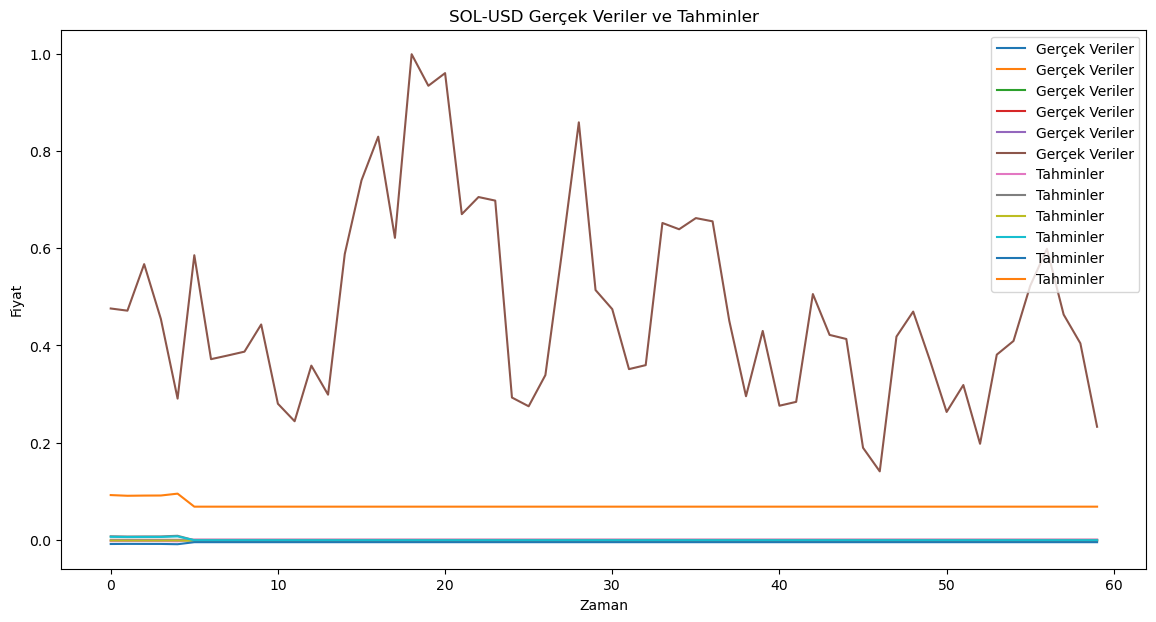

In [18]:
# her bir veri çerçevesi için tahminleri gerçek verilerle karşılaştıralım

# Her bir model için döngü oluşturun ve tahminleri gerçek verilerle karşılaştırın

for i in range(len(X_train_test_normalized)):
    # Gerçek verileri yükleyin
    y_test = X_train_test_normalized[i][3]
    
    # Tahminleri yükleyin
    predictions = np.load(f'datas/predictions/{tickers[i]}_predictions.npy')
    
    # Gerçek verileri ters ölçeklendirin
    y_test = (y_test * (y_test.max() - y_test.min())) + y_test.min()
    
    # Tahminleri ters ölçeklendirin
    predictions = (predictions * (y_test.max() - y_test.min())) + y_test.min()
    
    # Gerçek verileri ve tahminleri çizdirin
    plt.figure(figsize=(14, 7))
    plt.plot(y_test, label='Gerçek Veriler')
    plt.plot(predictions, label='Tahminler')
    plt.title(f'{tickers[i]} Gerçek Veriler ve Tahminler')
    plt.xlabel('Zaman')
    plt.ylabel('Fiyat')
    plt.legend()
    plt.show()
    

In [17]:
#TODO :  normalizasyon yapılacak : zerobase - minmax scaler  +

#TODO : seq2seq LSTM Yapılcak denenecek

#TODO : Dikkat Mekanizması ile LSTM yapılacak